# ⭐Final Project: 某闯关类手游用户流失预测
---
## 一、案例简介 🎮

手游在当下的日常娱乐中占据着主导性地位，成为人们生活中放松身心的一种有效途径。近年来，各种类型的手游，尤其是闯关类的休闲手游，由于其对碎片化时间的利用取得了非常广泛的市场。  
然而在此类手游中，新用户流失是一个非常严峻的问题，有相当多的新用户在短暂尝试后会选择放弃，而如果能在用户还没有完全卸载游戏的时候针对流失可能性较大的用户施以干预（例如奖励道具、暖心短信），  
就可能挽回用户从而提升游戏的活跃度和公司的潜在收益，因此用户的流失预测成为一个重要且挑战性的问题。  
在该项目中我们将从真实游戏中非结构化的日志数据出发，构建用户流失预测模型，综合已有知识设计适合的算法解决实际问题。

In [1]:
import pandas as pd
import numpy as np

## 二、数据概览 🥽

本项目使用的是一个休闲类闯关手游的数据，用户在游戏中不断闯关，每一关的基本任务是在限定步数内达到某个目标。  
每次闯关可能成功也可能失败，一般情况下用户只在完成一关后进入下一关，闯关过程中可以使用道具或提示等帮助。

对大多数手游来说，用户流失往往发生在早期，因此次周的留存情况是公司关注的一个重点。  
本次数据选取了 2020.2.1 注册的所有用户在 2.1-2.4 的交互数据，数据经过筛选保证这些注册用户在前四日至少有两日登录。  
流失的定义则参照次周（2.7-2.13）的登录情况，如果没有登录为流失。

本次的数据和以往结构化的形式不同，展现的是更原始的数据记录，更接近公司实际日志的形式，共包含 5 个文件：  
**level_seq.csv
/level_meta.csv
/train.csv
/dev.csv
/test.csv**

##### 🔰导入数据
- **训练集**："./data/" 📂路径下 *train.csv* 📝文件  
  包含总共 **8158** 条数据样本 💾
  每条样本包含 **user_id/label**

- **验证集**："./data/" 📂路径下 *dev.csv* 📝文件  
  包含总共 **2658** 条数据样本 💾
  每条样本包含 **user_id/label**  
  [🔧]：可进行超参数的的调整；也可作为离线测试集，进行测试
  
- **测试集**："./data/" 📂路径下 *test.csv* 📝文件  
  包含总共 **2773** 条数据样本 💾
  每条样本仅包含 **user_id**  
  [☁️]：测试集真实标签在云端，可上传结果评估性能

[📢]：所有文件 *user_id* 统一。  
✔️⚙️借助 **pandas** 读入标准 *csv* 格式文件的函数 `read_csv()` 将数据转换为 `DataFrame` 的形式。

### 🗃️level_seq.csv
💚核心数据文件💚  
包含用户游玩每个关卡的记录，每一条记录是对某个关卡的一次尝试，具体每列的含义如下：

* `user_id`：用户 id，和训练、验证、测试集中的可以匹配；
* `level_id`：关卡 id；
* `f_success`：是否通关（1：通关，0：失败）；
* `f_duration`：此次尝试所用的时间（单位 s）；
* `f_reststep`：剩余步数与限定步数之比（失败为 0）；
* `f_help`：是否使用了道具、提示等额外帮助（1：使用，0：未使用）；
* `time`：时间戳。

In [2]:
seq_df = pd.read_csv('./data/level_seq.csv', sep='\t')
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12
...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40


### 📮level_meta.csv
每个关卡的一些统计特征，可用于表示关卡，具体每列的含义如下：

* `f_avg_duration`：平均每次尝试花费的时间（单位 s，包含成功与失败的尝试）；
* `f_avg_passrate`：平均通关率；
* `f_avg_win_duration`：平均每次通关花费的时间（单位 s，只包含通关的尝试）；
* `f_avg_retrytimes`：平均重试次数（第二次玩同一关算第 1 次重试）；
* `level_id`：关卡 id，可以和 level_seq.csv 中的关卡匹配。

In [3]:
meta_df = pd.read_csv('./data/level_meta.csv', sep='\t')
meta_df

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.889940,0.944467,35.582757,0.017225,1
1,60.683975,0.991836,56.715706,0.004638,2
2,76.947355,0.991232,71.789943,0.004480,3
3,58.170347,0.993843,54.842882,0.004761,4
4,101.784577,0.954170,85.650547,0.027353,5
...,...,...,...,...,...
1504,594.878788,0.453730,133.625000,3.187500,1505
1505,486.562500,0.454180,115.906250,3.218750,1506
1506,325.968750,0.573525,86.250000,2.687500,1507
1507,793.096774,0.322684,164.000000,5.419355,1508


### 🚊train.csv

训练集用户，包括用户 *user_id*（从 1 开始）以及对应是否为流失用户的 label（1：流失，0：留存）。  
训练集共 8158 个用户，其中流失用户大约占 1/3 
 
[📢]：需要注意的是为了匿名化，这里数据都经过一定的非均匀抽样处理，流失率并不反映实际游戏的情况，  
用户与关卡的 id 同样经过了重编号，但对于流失预测任务来说并没有影响。

In [4]:
train_df = pd.read_csv('./data/train.csv', sep='\t')
train_df.T

,0,1,2,3,4,5,6,7,8,9,...,8148,8149,8150,8151,8152,8153,8154,8155,8156,8157
user_id,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,...,10922,10923,10924,10925,10926,10927,10928,10929,10930,10931
label,0,0,1,0,1,1,0,0,0,1,...,0,0,0,1,1,1,1,0,1,0


In [5]:
train_df['label'].value_counts()

0    5428
1    2730
Name: label, dtype: int64

### ⭕dev.csv

验证集格式和训练集相同，主要为了方便离线测试与模型选择。

In [6]:
dev_df = pd.read_csv('./data/dev.csv', sep='\t')
dev_df.T

,0,1,2,3,4,5,6,7,8,9,...,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657
user_id,10932,10933,10934,10935,10936,10937,10938,10939,10940,10941,...,13580,13581,13582,13583,13584,13585,13586,13587,13588,13589
label,0,1,0,1,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,1,0


### 🧪test.csv
测试集只包含用户 *user_id*，任务就是要预测这些用户的流失概率。

In [7]:
test_df = pd.read_csv('./data/test.csv', sep='\t')
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772
user_id,1,2,3,4,5,6,7,8,9,10,...,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773


## 三、特征工程 🧠
**某闯关类手游用户流失**  
针对用户提取特征
- **user_id** 用户ID 👽
- **num_attempts** 尝试次数 ⏳
- **clear_rate** 通关率 🎱
- **avg_duration** 平均用时 ⏱️
- **avg_reststep** 平均剩余步数比 👣
- **cum_help** 累积帮助次数 ✋
- **landing_days** 登陆天数 📅
- **label** 流失 ✔️❌

In [8]:
from collections import Counter

In [9]:
''' 
函数说明：根据 t_df 构建特征
Parameters:
    df - level_seq.csv 用户交互数据
    t_df - train.csv/dev.csv 训练集/验证集
Returns:
    features_df - 特征数据集(DataFrame)
'''
def Features_Construct(df,t_df):
    features = []

    for i,user in enumerate(t_df['user_id']):
        user_features = []
        user_id = user
        user_features.append(user_id)

        user_df = seq_df.query('user_id=={}'.format(user_id))
        # 用户尝试游戏次数
        user_features.append(user_df.shape[0])
        user_df_succ= user_df.query('f_success==1')
        # 通关率
        success_rate = round(user_df_succ.shape[0]/user_df.shape[0],6)
        user_features.append(success_rate)
        # 通过最高关卡
        # num_max = np.array(user_df_succ['level_id']).max()
        # user_features.append(num_max)
        # 游戏平均用时
        duration_mean = round(np.array(user_df['f_duration']).mean(),1)
        user_features.append(duration_mean)
        # 平均reststep
        reststep_mean = round(np.array(user_df['f_reststep']).mean(),6)
        user_features.append(reststep_mean)
        # 累积帮助次数
        times_help = np.array(user_df['f_help']).sum()
        user_features.append(times_help)
        # 登陆天数
        time = np.array(user_df['time'])
        day = [i[9] for i in time]
        dd = Counter(day)
        days = len(dd)
        user_features.append(days)
        
        features.append(user_features)

    features_df = pd.DataFrame(features)
    features_df.columns =['user_id','尝试游戏次数','通关率','游戏平均用时','平均剩余步数比','累积帮助次数','登陆天数']
    return features_df

In [10]:
# 训练集
train_features_df = Features_Construct(seq_df,train_df)
train_features_df['label'] = train_df['label']
train_features_df

,user_id,尝试游戏次数,通关率,游戏平均用时,平均剩余步数比,累积帮助次数,登陆天数,label
0,2774,215,0.632558,118.1,0.189056,18,4,0
1,2775,111,0.738739,169.7,0.258456,14,3,0
2,2776,69,0.637681,88.7,0.186543,1,3,1
3,2777,286,0.506993,142.7,0.124245,4,4,0
4,2778,162,0.672840,197.8,0.299450,9,3,1
...,...,...,...,...,...,...,...,...
8153,10927,350,0.505714,99.1,0.166471,10,4,1
8154,10928,50,1.000000,81.5,0.471203,3,2,1
8155,10929,243,0.469136,118.8,0.117959,14,3,0
8156,10930,39,0.948718,156.9,0.380187,6,2,1


In [11]:
# 验证集
dev_features_df = Features_Construct(seq_df,dev_df)
dev_features_df['label'] = dev_df['label']
dev_features_df

,user_id,尝试游戏次数,通关率,游戏平均用时,平均剩余步数比,累积帮助次数,登陆天数,label
0,10932,222,0.504505,185.3,0.143857,20,4,0
1,10933,86,0.604651,110.3,0.189069,4,3,1
2,10934,97,0.731959,110.4,0.265445,7,3,0
3,10935,20,0.750000,90.6,0.339879,2,3,1
4,10936,229,0.524017,145.4,0.115141,22,4,0
...,...,...,...,...,...,...,...,...
2653,13585,248,0.451613,109.8,0.119008,12,3,0
2654,13586,311,0.446945,125.1,0.108392,16,3,0
2655,13587,20,0.700000,109.8,0.228793,0,2,0
2656,13588,28,0.964286,75.6,0.441202,0,2,1


In [12]:
# 测试集
test_features_df = Features_Construct(seq_df,test_df)
test_features_df

,user_id,尝试游戏次数,通关率,游戏平均用时,平均剩余步数比,累积帮助次数,登陆天数
0,1,395,0.263291,98.4,0.060526,8,4
1,2,237,0.514768,85.2,0.150546,20,4
2,3,230,0.608696,96.9,0.235325,14,2
3,4,107,0.532710,123.7,0.143748,8,4
4,5,238,0.420168,123.8,0.118816,20,4
...,...,...,...,...,...,...,...
2768,2769,41,0.829268,80.3,0.324696,3,3
2769,2770,411,0.501217,101.2,0.147572,18,4
2770,2771,255,0.701961,95.4,0.198157,15,4
2771,2772,87,0.632184,119.9,0.211336,1,2


## 四、数据集构建 📡
- ⚠️**归一化：Min-Max Normalization**  
  - $\frac{x_{i}-min(x_i)}{max(x_i)-min(x_i)}$ 
- **DataFrame** 转换→ **Array**

In [13]:
''' 
函数说明：对数据进行归一化
Parameters:
    dataSet - 特征矩阵
Returns:
    normDataSet - 归一化后的特征矩阵
'''
def autoNorm(dataSet):
    # 获得数据的最小值
    minVals = dataSet.min(0)
    maxVals = dataSet.max(0)
    # 最大值和最小值的范围
    ranges = maxVals - minVals
    # shape(dataSet)返回dataSet的矩阵行列数
    normDataSet = np.zeros(np.shape(dataSet))
    # 返回dataSet的行数
    m = dataSet.shape[0]
    # 原始值减去最小值
    normDataSet = dataSet - np.tile(minVals, (m, 1))
    # 除以最大和最小值的差,得到归一化数据
    normDataSet = normDataSet / np.tile(ranges, (m, 1))
    # 返回归一化数据结果,数据范围,最小值
    return normDataSet

In [14]:
# 训练集
train_features = np.array(train_features_df.iloc[:, 1:7])
train_features = autoNorm(train_features) # 归一化
train_labels = train_features_df.iloc[:, -1].values
# 验证集
dev_features = np.array(dev_features_df.iloc[:, 1:7])
dev_features = autoNorm(dev_features) # 归一化
dev_labels = dev_features_df.iloc[:, -1].values
train_features.shape,train_labels.shape,dev_features.shape,dev_labels.shape

((8158, 6), (8158,), (2658, 6), (2658,))

In [15]:
# 测试集
test_features = np.array(test_features_df.iloc[:, 1:7])
test_features = autoNorm(test_features) # 归一化
test_features.shape

(2773, 6)

## 五、模型构建 🧰

1. ❤️ **DecisionTree(DT)** 
2. 💛 **NaiveBayes(NB)** 
3. 💚 **K-Nearest Neighbor(KNN)** 
4. 💙 **Support Vector Machine(SVM)** 
5. 💜 **Ensemble learning** 
   - 🖤 **Bagging+** 
   - 🤍 **Adaboost+** 

In [16]:
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [17]:
p_list = [] # 记录模型预测结果（0/1）
pro_list = [] # 记录模型预测结果（probability）

#### **1.决策树**
**sklearn.tree.DecisionTreeClassifier** 🌵
```python
class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, 
min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, 
min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
```

In [18]:
parameters = {'criterion':['entropy', 'gini'], 
              'max_depth': range(1, 6), 
              'min_samples_split': [50, 100, 200, 500, 1000]} # 定义需要遍历的参数
DT = tree.DecisionTreeClassifier() # 定义决策树，可以不传参数，由GridSearchCV传入构建
grid_search = GridSearchCV(DT, parameters, scoring='accuracy', cv=5, verbose=100, n_jobs=4) # 传入模型和要遍历的参数
grid_search.fit(train_features,train_labels) # 在所有数据上搜索参数
print(grid_search.best_score_, grid_search.best_params_) # 输出最佳指标和最佳参数

DT = tree.DecisionTreeClassifier(**grid_search.best_params_)  # 取最佳参数
DT.fit(train_features,train_labels) # 在训练集上训练
p_test = DT.predict(dev_features) # 在测试集上预测，获得预测值
print(p_test) # 输出预测值
p_list.append(p_test)
pro_test = DT.predict_proba(dev_features)
pro_list.append(pro_test)
test_acc = accuracy_score(p_test, dev_labels) # 将测试预测值与测试集标签对比获得准确率
test_prec = precision_score(p_test, dev_labels)
test_rec = recall_score(p_test, dev_labels)
test_AUC = roc_auc_score(dev_labels,pro_test[:,1])
print('>> accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(test_acc, test_prec, test_rec)) # 输出评价指标
print('>> AUC: {:.4f}'.format(test_AUC))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0.7391579056515309 {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 50}
[0 0 0 ... 1 1 1]
>> accuracy: 0.7397, precision: 0.5239, recall: 0.6422
>> AUC: 0.7663


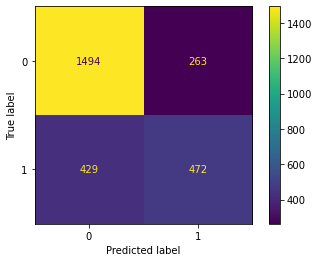

In [19]:
cm = confusion_matrix(dev_labels, p_test, labels=[0, 1])
cm_displ = ConfusionMatrixDisplay(cm)
cm_displ.plot()
plt.show()

#### **2.贝叶斯**
**sklearn.naive_bayes.BernoulliNB/ MultinomialNB/ ComplementNB** 🧐
```python
class sklearn.naive_bayes.BernoulliNB(*, alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
class sklearn.naive_bayes.MultinomialNB(*, alpha=1.0, fit_prior=True, class_prior=None)
class sklearn.naive_bayes.ComplementNB(*, alpha=1.0, fit_prior=True, class_prior=None, norm=False)
```

In [20]:
for NB in [BernoulliNB(), MultinomialNB(), ComplementNB()]: # 测试三种类型的朴素贝叶斯
    NB.fit(train_features,train_labels) # 在训练集上训练
    p_test = NB.predict(dev_features) # 在测试集上预测，获得预测值
    test_acc = accuracy_score(dev_labels, p_test) # 准确率
    test_prec = precision_score(dev_labels, p_test) # 精准率
    test_rec = recall_score(dev_labels, p_test) # 召回率
    test_AUC = roc_auc_score(dev_labels,pro_test[:,1])
    print(NB)
    print(p_test)
    print('>> accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(test_acc, test_prec, test_rec)) # 输出评价指标
    print('>> AUC: {:.4f}'.format(test_AUC))
    
NB = BernoulliNB()
NB.fit(train_features,train_labels)
p_test = NB.predict(dev_features)
p_list.append(p_test)
pro_test = NB.predict_proba(dev_features)
pro_list.append(pro_test)

BernoulliNB()
[0 0 0 ... 1 1 1]
>> accuracy: 0.7400, precision: 0.6427, recall: 0.5250
>> AUC: 0.7663
MultinomialNB()
[0 0 0 ... 0 0 0]
>> accuracy: 0.6614, precision: 0.6667, recall: 0.0022
>> AUC: 0.7663
ComplementNB()
[0 0 1 ... 1 1 1]
>> accuracy: 0.7284, precision: 0.5844, recall: 0.6881
>> AUC: 0.7663


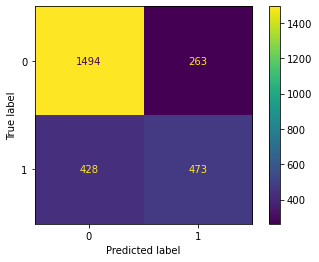

In [21]:
cm = confusion_matrix(dev_labels, p_test, labels=[0, 1])
cm_displ = ConfusionMatrixDisplay(cm)
cm_displ.plot()
plt.show()

#### **3.k-近邻**
**sklearn.neighbors.KNeighborsClassifier** 🛵
```python
class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', 
leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
```

In [22]:
parameters = {'n_neighbors': range(1, 30),
              'weights':['uniform', 'distance'],
              'metric':['euclidean', 'manhattan', 'chebyshev', 'minkowski']}
KNN = KNeighborsClassifier()
grid_search = GridSearchCV(KNN, parameters, scoring='accuracy', cv=5, verbose=100, n_jobs=4)
grid_search.fit(train_features,train_labels) # 在所有数据上搜索参数
print(grid_search.best_score_, grid_search.best_params_) # 输出最佳指标和最佳参数

KNN = KNeighborsClassifier(**grid_search.best_params_)  # 取最佳参数
KNN.fit(train_features,train_labels) # 在训练集上训练
p_test = KNN.predict(dev_features) # 在测试集上预测，获得预测值
print(p_test) # 输出预测值
p_list.append(p_test)
pro_test = KNN.predict_proba(dev_features)
pro_list.append(pro_test)
test_acc = accuracy_score(p_test, dev_labels) # 将测试预测值与测试集标签对比获得准确率
test_prec = precision_score(p_test, dev_labels)
test_rec = recall_score(p_test, dev_labels)
test_AUC = roc_auc_score(dev_labels,pro_test[:,1])

print('>> accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(test_acc, test_prec, test_rec)) # 输出评价指标
print('>> AUC: {:.4f}'.format(test_AUC))


Fitting 5 folds for each of 232 candidates, totalling 1160 fits
0.7310666648633702 {'metric': 'chebyshev', 'n_neighbors': 29, 'weights': 'uniform'}
[0 0 0 ... 1 1 1]
>> accuracy: 0.7261, precision: 0.4961, recall: 0.6200
>> AUC: 0.7624


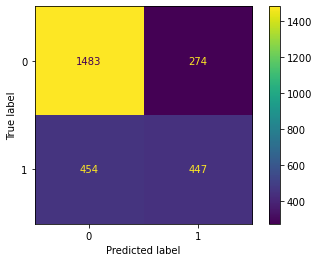

In [23]:
cm = confusion_matrix(dev_labels, p_test, labels=[0, 1])
cm_displ = ConfusionMatrixDisplay(cm)
cm_displ.plot()
plt.show()

#### **4.SVM**
**sklearn.svm.SVC** 🛒
```python
class sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, 
tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
```

In [24]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 
grid_search  = GridSearchCV(SVC(),param_grid,scoring='accuracy', cv=5, verbose=100, n_jobs=4)
grid_search.fit(train_features,train_labels)
print(grid_search.best_score_, grid_search.best_params_)

SVM = SVC(probability=True,**grid_search.best_params_)  # 取最佳参数
SVM.fit(train_features,train_labels) # 在训练集上训练
p_test = SVM.predict(dev_features) # 在测试集上预测，获得预测值
print(p_test) # 输出预测值
p_list.append(p_test)
pro_test = SVM.predict_proba(dev_features)
pro_list.append(pro_test)
test_acc = accuracy_score(p_test, dev_labels) 
test_prec = precision_score(p_test, dev_labels)
test_rec = recall_score(p_test, dev_labels)
test_AUC = roc_auc_score(dev_labels,pro_test[:,1])

print('>> accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(test_acc, test_prec, test_rec)) # 输出评价指标
print('>> AUC: {:.4f}'.format(test_AUC))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
0.7394033793775021 {'C': 1, 'gamma': 0.01}
[0 0 0 ... 1 1 1]
>> accuracy: 0.7393, precision: 0.5239, recall: 0.6413
>> AUC: 0.7730


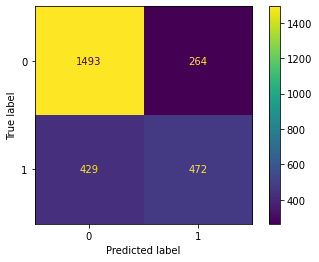

In [25]:
cm = confusion_matrix(dev_labels, p_test, labels=[0, 1])
cm_displ = ConfusionMatrixDisplay(cm)
cm_displ.plot()
plt.show()

#### **5.集成学习**
基分类器⚾  
参数分别根据 **1-4** 最佳 **Accuracy** 选择
- 🌵DT：  `DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=50)`
- 🧐NB：  `BernoulliNB()`
- 🛵KNN： `KNeighborsClassifier(metric='chebyshev', n_neighbors=29, weights='uniform')`
- 🛒SVM： `SVC(C=1, kernel='rbf', gamma=0.01)`


In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

##### **Bagging+**
**sklearn.ensemble.BaggingClassifier** 🛍️
```python
class sklearn.ensemble.BaggingClassifier(base_estimator=None, n_estimators=10, *, max_samples=1.0, max_features=1.0, 
bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)
```

In [39]:
p_list_Bagging = [] # 记录Bagging+模型预测结果（0/1）
pro_list_Bagging = [] # 记录Bagging+模型预测结果（probability）

In [40]:
for baseclf in [tree.DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=50),
                BernoulliNB(),
                KNeighborsClassifier(metric='chebyshev', n_neighbors=29, weights='uniform'),
                SVC(C=1, kernel='rbf', gamma=0.01,probability=True)]:
    Bagging_ = BaggingClassifier(baseclf)
    Bagging_.fit(train_features,train_labels)
    p_test = Bagging_.predict(dev_features)
    p_list_Bagging.append(p_test)
    pro_test = Bagging_.predict_proba(dev_features)
    pro_list_Bagging.append(pro_test)
    
    test_acc = accuracy_score(p_test, dev_labels)
    test_prec = precision_score(p_test, dev_labels) 
    test_rec = recall_score(p_test, dev_labels)
    test_AUC = roc_auc_score(dev_labels,pro_test[:,1])
    
    print(baseclf)
    print('>> accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(test_acc, test_prec, test_rec)) # 输出评价指标
    print('>> AUC: {:.4f}'.format(test_AUC))

DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=50)
>> accuracy: 0.7397, precision: 0.5239, recall: 0.6422
>> AUC: 0.7703
BernoulliNB()
>> accuracy: 0.7400, precision: 0.5250, recall: 0.6427
>> AUC: 0.7045
KNeighborsClassifier(metric='chebyshev', n_neighbors=29)
>> accuracy: 0.7261, precision: 0.4950, recall: 0.6203
>> AUC: 0.7606
SVC(C=1, gamma=0.01, probability=True)
>> accuracy: 0.7397, precision: 0.5239, recall: 0.6422
>> AUC: 0.7764


##### **AdaBoost+**
**sklearn.ensemble.AdaBoostClassifier** 🥾
```python
class sklearn.ensemble.AdaBoostClassifier(base_estimator=None, *, n_estimators=50, 
learning_rate=1.0, algorithm='SAMME.R', random_state=None)
```

In [29]:
p_list_Adaboost = [] # 记录Adaboost+模型预测结果（0/1）
pro_list_Adaboost = [] # 记录Adaboost+模型预测结果（probability）

In [30]:
for baseclf in [tree.DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=50),
                BernoulliNB(),
                SVC(C=1, kernel='rbf', gamma=0.01,probability=True)]:
    Adaboost_ = AdaBoostClassifier(baseclf,algorithm='SAMME')
    Adaboost_.fit(train_features,train_labels)
    p_test = Adaboost_.predict(dev_features)
    p_list_Adaboost.append(p_test)
    pro_test = Adaboost_.predict_proba(dev_features)
    pro_list_Adaboost.append(pro_test)
    
    test_acc = accuracy_score(p_test, dev_labels)
    test_prec = precision_score(p_test, dev_labels) 
    test_rec = recall_score(p_test, dev_labels)
    test_AUC = roc_auc_score(dev_labels,pro_test[:,1])
    
    print(baseclf)
    print('>> accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(test_acc, test_prec, test_rec)) # 输出评价指标
    print('>> AUC: {:.4f}'.format(test_AUC))

DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=50)
>> accuracy: 0.7265, precision: 0.3840, recall: 0.6680
>> AUC: 0.7826
BernoulliNB()
>> accuracy: 0.7397, precision: 0.5239, recall: 0.6422
>> AUC: 0.7045
SVC(C=1, gamma=0.01, probability=True)
>> accuracy: 0.6610, precision: 0.0000, recall: 0.0000
>> AUC: 0.5000


g:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 六、模型评估 ROC/AUC 📐

#### **🌵DT/ 🧐NB/ 🛵KNN/ 🛒SVM**

In [31]:
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [32]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(dev_labels, pro_list[i][:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

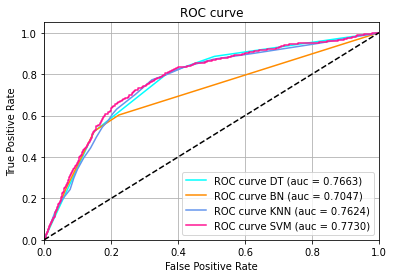

In [33]:
plt.figure()
colors = cycle(["aqua", "darkorange", "cornflowerblue","deeppink"])
models = cycle(["DT","BN","KNN","SVM"])
for i, color,model in zip(range(4), colors, models):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve {0} (auc = {1:0.4f})".format(model, roc_auc[i]),
    )
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.grid("open")
plt.show()

#### 🥡**Ensemble learning+ AUC 对比**

In [41]:
for i,model in enumerate(["Bagging + D_T","Bagging + B_N","Bagging + KNN","Bagging + SVM"]):
    auc = roc_auc_score(dev_labels,pro_list_Bagging[i][:,1])
    print("{0} model: \n>> AUC = {1:.4f}".format(model,auc))

Bagging + D_T model: 
>> AUC = 0.7703
Bagging + B_N model: 
>> AUC = 0.7045
Bagging + KNN model: 
>> AUC = 0.7606
Bagging + SVM model: 
>> AUC = 0.7764


In [35]:
for i,model in enumerate(["Adaboost + D_T","Adaboost + B_N","Adaboost + SVM"]):
    auc = roc_auc_score(dev_labels,pro_list_Adaboost[i][:,1])
    print("{0} model: \n>> AUC = {1:.4f}".format(model,auc))

Adaboost + D_T model: 
>> AUC = 0.7826
Adaboost + B_N model: 
>> AUC = 0.7045
Adaboost + SVM model: 
>> AUC = 0.5000


## 七、测试集 result.csv ☁️

**Best model**💯  
Adaboost + D_T model  
\>\> AUC(dev) = 0.7826  

- **Adaboost + D_T model** 👈

result.csv 需要对测试集中每一个用户给出预测流失的概率  
每行包括一个 *ID*（和 test.csv 中的user_id对应）以及预测的概率 *Prediction*（0-1的浮点数），用逗号分隔。

In [36]:
base = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=50)
TEST = Adaboost_ = AdaBoostClassifier(base,algorithm='SAMME')
TEST.fit(train_features,train_labels)
pro_test = TEST.predict_proba(test_features)

test_df['Prediction'] = pro_test[:,1]
test_df.rename(columns={'user_id':'ID'},inplace=True)
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772
ID,1.000000,2.000000,3.000000,4.000000,5.00000,6.000000,7.00000,8.000000,9.000000,10.000000,...,2764.000000,2765.00000,2766.00000,2767.000000,2768.000000,2769.00000,2770.000000,2771.00000,2772.000000,2773.000000
Prediction,0.292253,0.348539,0.487569,0.359274,0.32392,0.353699,0.49843,0.295529,0.298647,0.499304,...,0.348539,0.42741,0.37536,0.565907,0.543973,0.48539,0.338248,0.37856,0.471779,0.483752


In [37]:
# DataFrame 转 .csv
test_df.to_csv(r'./result.csv',index=False)

[☁️]：**打榜成绩**⏫  
**Adaboost + D_T model**  
\>\> **AUC(test) = 0.77304** ❗❗❗